In [1]:
import seaborn as sns
import spacy
import nltk
from nltk import bigrams
#from nltk.corpus import stopwords
import pandas as pd
import itertools
import collections
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from textblob import TextBlob
import numpy as np
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import datetime
import matplotlib.dates as mdates 

In [2]:
# input tweets from pickle file (They have been cleaned allready)
tweets = pd.read_pickle("/Users/tomashegewisch/Desktop/all_6_months.pkl")
d1 = "2020-03-01"
d2 = "2020-08-31"
def get_date_range_for_tweet(date):
    date_1 = datetime.datetime.strptime(d1,'%Y-%m-%d')
    date_2 = datetime.datetime.strptime(d2,'%Y-%m-%d')
    date = date.to_pydatetime().strftime("%Y-%m-%d")
    date = datetime.datetime.strptime(date,'%Y-%m-%d')
    if date >= date_1 and date <= date_2:
        return True
    else:
        return False

# Remove tweets that are out of the date range 
tweets = tweets[tweets['date'].apply(lambda x : get_date_range_for_tweet(x)) == True]

In [3]:
# Create a dataframe from all the words that have been tokenised
word_list = [] 
for i in tweets['tokenised']:
    for j in i:
        if j != "amp":
            word_list.append(j)
word_list = pd.DataFrame(word_list)

In [4]:
# Process a Sentimnet value for each tweet.
def get_sent(text):
    return TextBlob(text).sentiment.polarity
tweets['senti_values'] = tweets['tweet_clean'].apply(lambda x : get_sent(x))

In [6]:
# Create bar chart showing Sentimnet for the top 10 most common words.
word_list_counter = Counter(word_list[0])
def get_sent_for_top_words(text, lookout_word):
    if lookout_word not in text:
        return None
    else:
        return TextBlob(text).sentiment.polarity

for i in word_list_counter.most_common(10):
    tweet_senti_values = tweets['tweet_clean'].apply(lambda x : get_sent_for_top_words(x, i[0]))
    tweet_senti_values = tweet_senti_values.dropna(axis=0, inplace=False, how=None)
    #tweet_senti_values.hist()
    plt.hist(tweet_senti_values)
    plt.title('Sentiment around the word: ' + i[0])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/barchart/barchart_Sentiment_"+i[0]+".png")
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [7]:
# Split positive and negitive tweets into two diffrent data frame columes.
def get_value_positive(x):
    if x > 0.0:
        return x
    else:
        return None

def get_value_negitive(x):
    if x < 0.0:
        return x
    else:
        return None
# we have removed the 0 from both.  
tweets["positve"] = tweets['senti_values'].apply(get_value_positive)
tweets["negitive"] = tweets['senti_values'].apply(get_value_negitive)

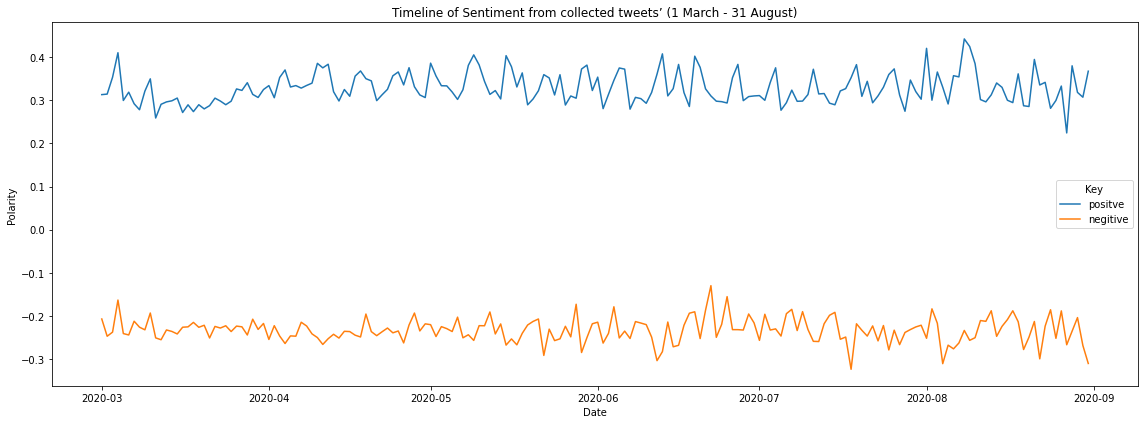

<Figure size 432x288 with 0 Axes>

In [8]:
# dis
positive_date_mean = tweets.groupby('date', as_index=False)['positve'].mean()
negitive_date_mean = tweets.groupby('date', as_index=False)['negitive'].mean()
display_df_average = positive_date_mean
display_df_average['negitive'] = negitive_date_mean['negitive']
plt.figure(figsize=(16, 6))
sns.lineplot(x='Date',
             y='Polarity', 
             hue='Key',
             data= pd.melt(display_df_average, ['date']).rename(columns={"value": "Polarity","variable":"Key", "date":"Date"})
            ).set_title("Timeline of Sentiment from collected tweets’ (1 March - 31 August)").get_figure()
plt.tight_layout()
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Sentiment_"+"Timeline of sentiment from collected tweets.png")
plt.show()
plt.clf()

In [9]:
def get_key_word(text, kw):
    if kw in text:
        return True
    else:
        return "no"
    
# want to find the date range 
def get_the_date(month_code):
    moths_dates = {1:['2020-03-01','2020-03-31',"March"],
                  2:['2020-04-01','2020-04-30', "April"],
                  3:['2020-05-01','2020-05-31', "May"],
                  4:['2020-06-01','2020-06-30', "June"],
                  5:['2020-07-01','2020-07-31', "July"],
                  6:['2020-08-01','2020-08-31', "August"],
                  7:['2020-09-01','2020-09-30', "September"],
                  8:['2020-10-01','2020-10-31', "October"]}
    return moths_dates[month_code]

# retrunr if the date is not in the rage
def get_date_range(date, d1, d2):
    date_1 = datetime.datetime.strptime(d1,'%Y-%m-%d')
    date_2 = datetime.datetime.strptime(d2,'%Y-%m-%d')
    date = date.to_pydatetime().strftime("%Y-%m-%d")
    date = datetime.datetime.strptime(date,'%Y-%m-%d')
    if date >= date_1 and date <= date_2:
        return True
    else:
        return False
    
# group by date

for i in range(1,9):
    nedded_dates = get_the_date(i)
    for i in word_list_counter.most_common(1):
        # select start and end date
        # Drop The columes that do not include the key_word
        key_word = i[0]
        key_word_sentimnet_score_all = tweets[tweets['tweet'].apply(lambda x : get_key_word(x,key_word)) == True]
        key_word_sentimnet_score_all = key_word_sentimnet_score_all[key_word_sentimnet_score_all['date'].apply(lambda x : get_date_range(x, nedded_dates[0], nedded_dates[1])) == True]
        #Group by
        positive_date_mean = key_word_sentimnet_score_all.groupby('date', as_index=False)['positve'].mean()
        negitive_date_mean = key_word_sentimnet_score_all.groupby('date', as_index=False)['negitive'].mean()
        # ASK RICH ABOUT THIS SECTION OF CODE>>> What it does is adds the prvious value to the NaN sections.
        NaN_test = pd.isnull(positive_date_mean)
        temp = 0.0 
        for i in range(0, len(NaN_test)):
            try:
                if NaN_test['positve'][i] == True:

                    positive_date_mean['positve'][i] = temp
                else:
                    temp = positive_date_mean['positve'][i]
            except:
                continue
        NaN_test = pd.isnull(negitive_date_mean)
        temp = 0.0
        for i in range(0, len(NaN_test)):
            try:
                if NaN_test['negitive'][i] == True:
                    negitive_date_mean['negitive'][i] = temp
                else:
                    temp = negitive_date_mean['negitive'][i]
            except:
                continue 

        # Dsiplay The plot.
        display_df_average = positive_date_mean
        display_df_average['negitive'] = negitive_date_mean['negitive']
        plt.figure(figsize=(16, 6))
        sns.lineplot(x='Date', y='Polarity', hue='Key', 
             data=pd.melt(display_df_average, ['date']).rename(columns={"value": "Polarity","variable":"Key", "date":"Date"})).set_title("The Sentiment for " + str(nedded_dates[2]) + " of Topic: "+key_word).get_figure().autofmt_xdate()
        plt.tight_layout()
        plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/line_sentiment/Sentiment_"+key_word+"_"+str(nedded_dates[2])+".png")
        plt.clf()

<ipython-input-9-a25e5fb3d329>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negitive_date_mean['negitive'][i] = temp
<ipython-input-9-a25e5fb3d329>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_date_mean['positve'][i] = temp
<ipython-input-9-a25e5fb3d329>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negitive_date_mean['negitive'][i] = temp
<ipython-input-9-a25e5fb3d329>:50: SettingWithCopyWarning: 
A value is try

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

['2020-04-09', '2020-04-22']


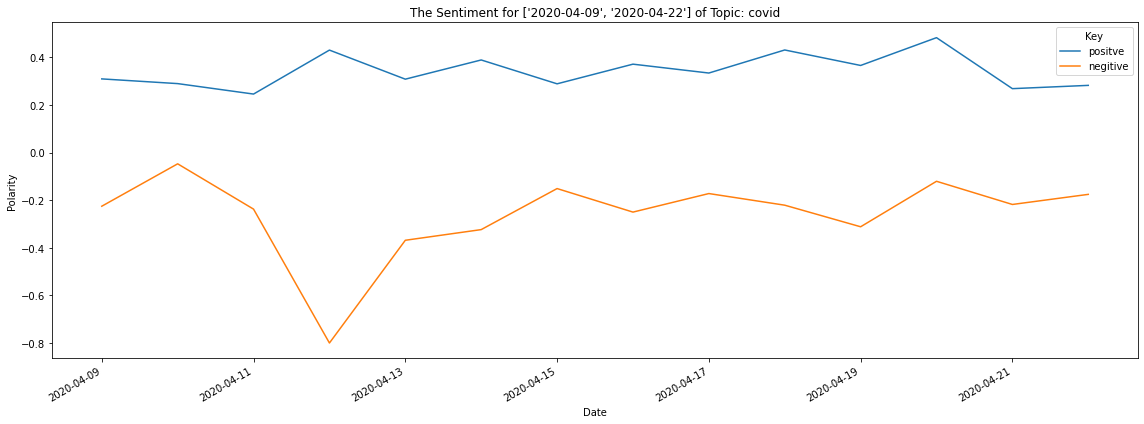

<Figure size 432x288 with 0 Axes>

In [10]:
#drill down code
def drill_down_date_topic(topic_word, date_1, date_2):
    key_word = topic_word
    nedded_dates = [date_1, date_2]
    key_word_sentimnet_score_all = tweets[tweets['tweet'].apply(lambda x : get_key_word(x,key_word)) == True]
    key_word_sentimnet_score_all = key_word_sentimnet_score_all[key_word_sentimnet_score_all['date'].apply(lambda x : get_date_range(x, nedded_dates[0], nedded_dates[1])) == True]
    positive_date_mean = key_word_sentimnet_score_all.groupby('date', as_index=False)['positve'].mean()
    negitive_date_mean = key_word_sentimnet_score_all.groupby('date', as_index=False)['negitive'].mean()
    # ASK RICH ABOUT THIS SECTION OF CODE>>> What it does is adds the prvious value to the NaN sections.
    NaN_test = pd.isnull(positive_date_mean)
    temp = 0.0 
    for i in range(0, len(NaN_test)):
        try:
            if NaN_test['positve'][i] == True:
                positive_date_mean['positve'][i] = temp
            else:
                temp = positive_date_mean['positve'][i]
        except:
            continue
    NaN_test = pd.isnull(negitive_date_mean)
    temp = 0.0
    for i in range(0, len(NaN_test)):
        try:
            if NaN_test['negitive'][i] == True:
                negitive_date_mean['negitive'][i] = temp
            else:
                temp = negitive_date_mean['negitive'][i]
        except:
            continue 

        # Dsiplay The files.
    display_df_average = positive_date_mean
    display_df_average['negitive'] = negitive_date_mean['negitive']
    plt.figure(figsize=(16, 6))
    sns.lineplot(x='Date',
                 y='Polarity',
                 hue='Key',
                 data=pd.melt(display_df_average, 
                              ['date']).rename(columns={"value": "Polarity","variable":"Key", "date":"Date"})).set_title("The Sentiment for " + str(nedded_dates) + " of Topic: "+key_word).get_figure().autofmt_xdate()
    plt.tight_layout()
    print(nedded_dates)
    plt.show()
    #plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Sentiment_"+key_word+"_"+str(nedded_dates[0])+"_"+str(nedded_dates[1])+".png")
    plt.clf()

drill_down_date_topic("covid", '2020-04-09', '2020-04-22')

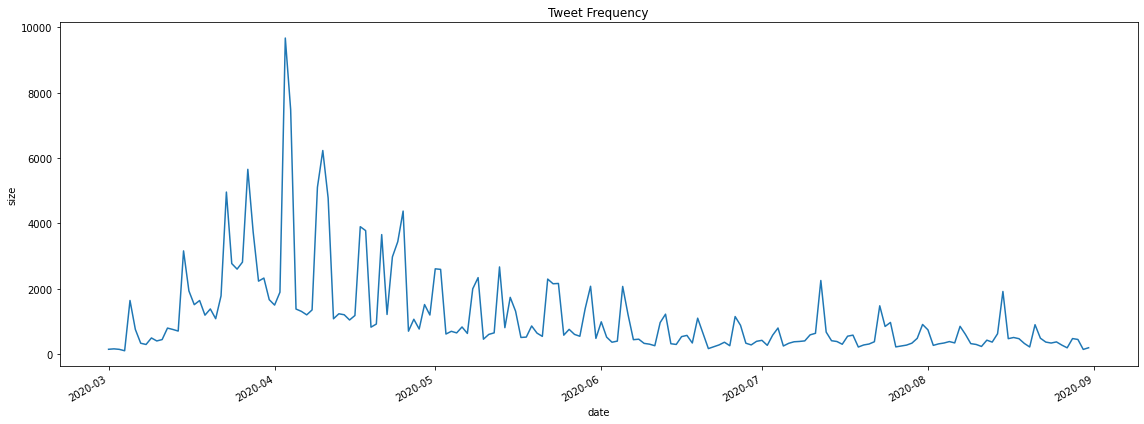

<Figure size 432x288 with 0 Axes>

In [11]:
#Frequency of posting
post_feq = tweets.groupby('date', as_index=False).size()
post_feq
plt.figure(figsize=(16, 6))
sns.lineplot(x='date',
                 y='size',
                 data=post_feq).set_title("Tweet Frequency").get_figure().autofmt_xdate()
plt.tight_layout()
plt.show()
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/tweet_frequency.png")
plt.clf()

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_covid19.png


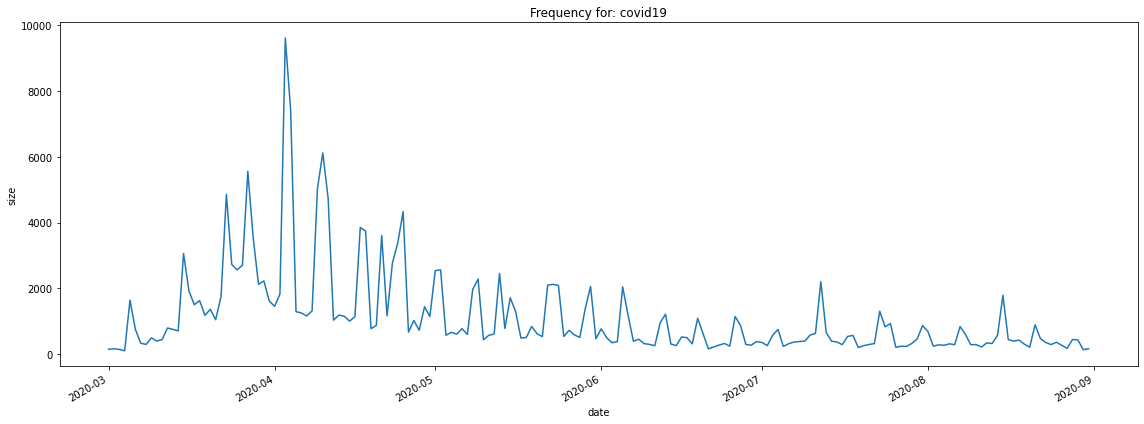

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_southafrica.png


<Figure size 432x288 with 0 Axes>

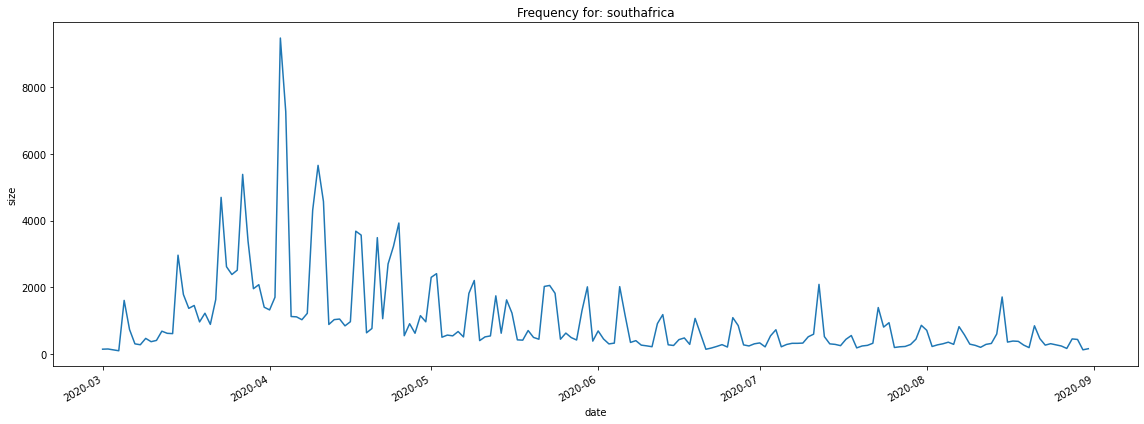

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_lockdownsa.png


<Figure size 432x288 with 0 Axes>

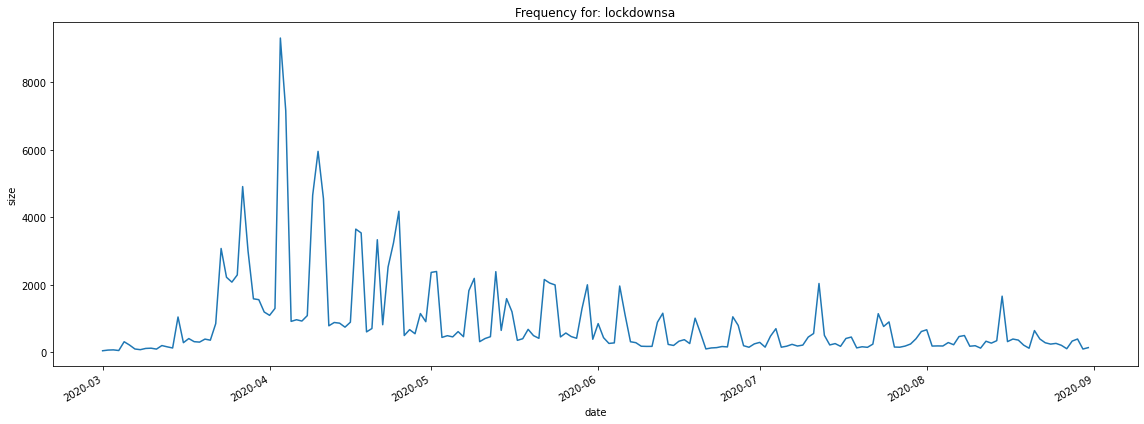

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_cyrilramaphosa.png


<Figure size 432x288 with 0 Axes>

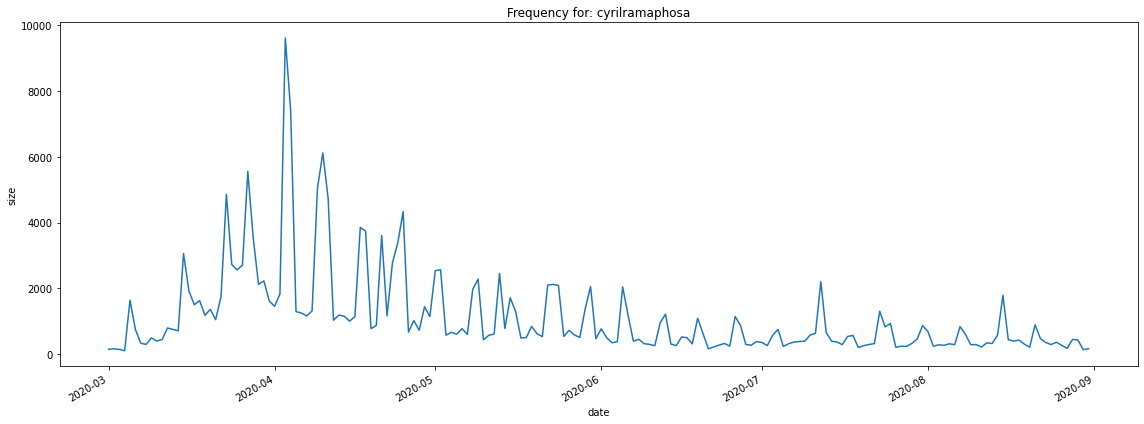

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_lockdown.png


<Figure size 432x288 with 0 Axes>

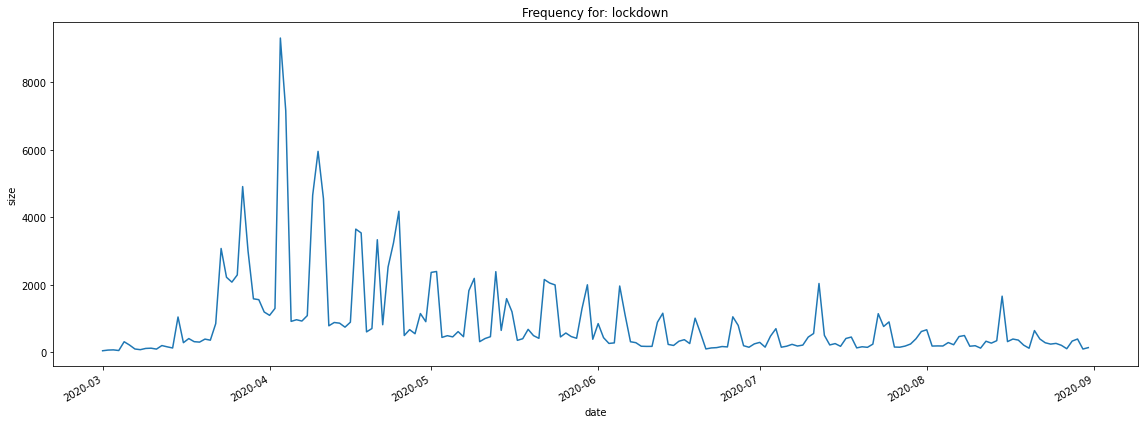

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_covid19sa.png


<Figure size 432x288 with 0 Axes>

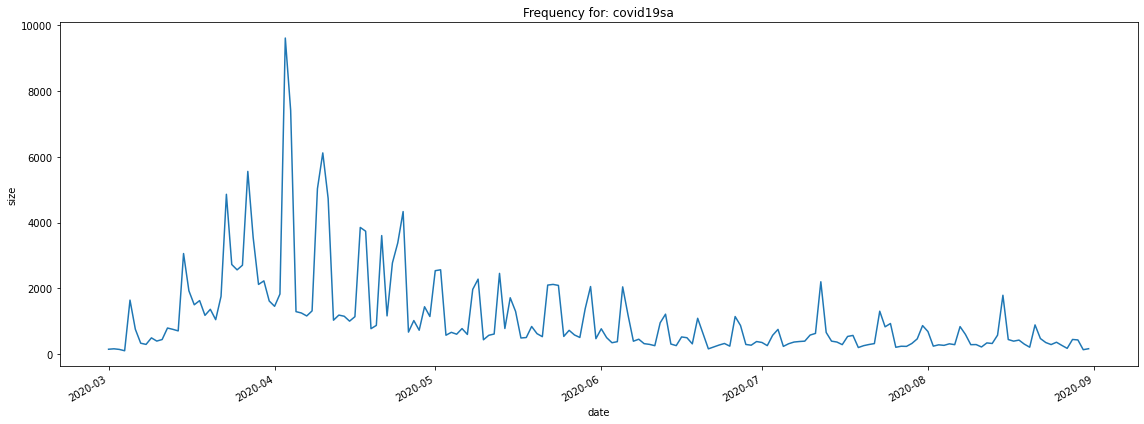

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_coronavirussa.png


<Figure size 432x288 with 0 Axes>

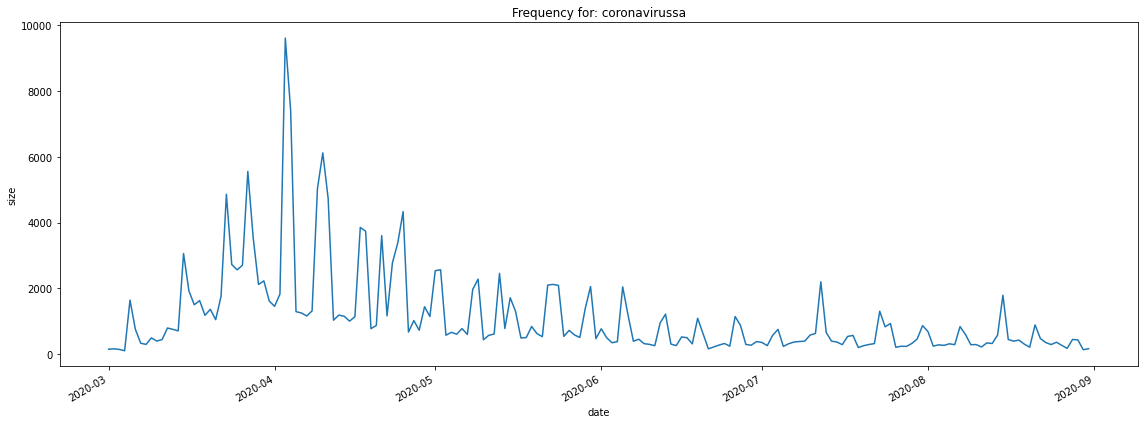

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_covid_19.png


<Figure size 432x288 with 0 Axes>

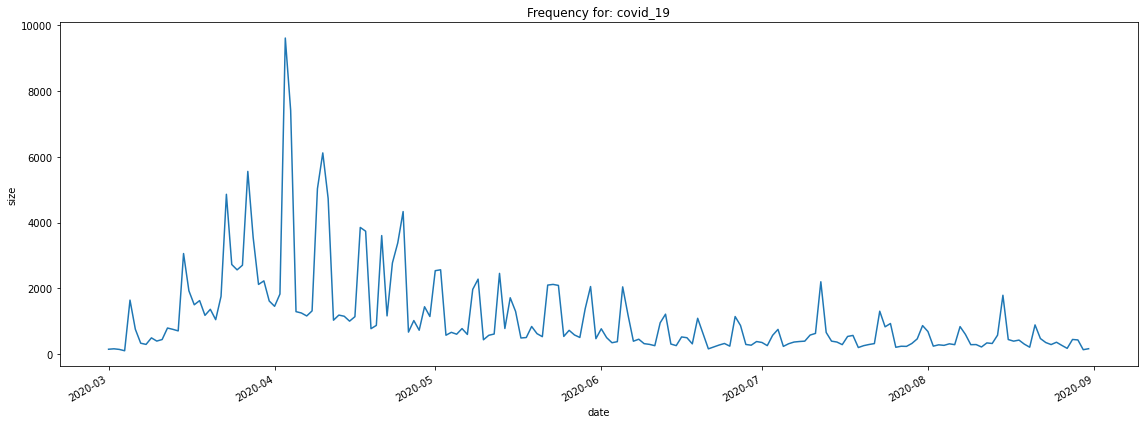

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_lockdownsouthafrica.png


<Figure size 432x288 with 0 Axes>

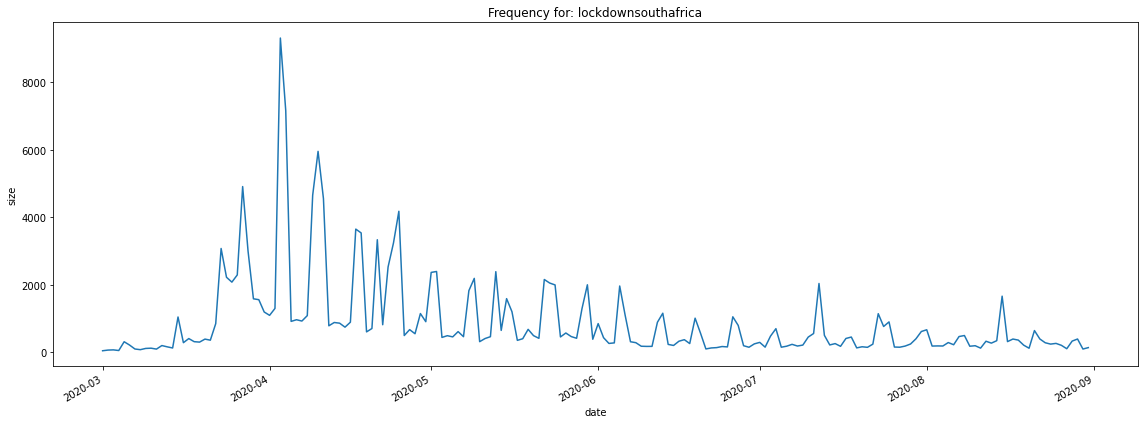

/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_government.png


<Figure size 432x288 with 0 Axes>

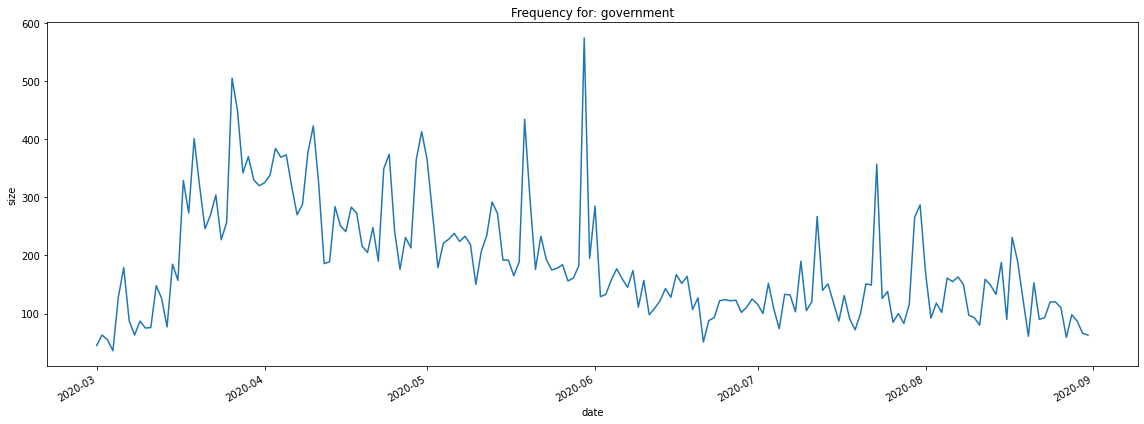

<Figure size 432x288 with 0 Axes>

In [59]:
# plot the timeline frequency for popular hastags for the 6 months. 
def get_time_line_of_hastages(find_word):
    def get_if_hastag(htags_list):
        for i in htags_list:
            for j in i:
                if j == find_word[0]:
                    return True
        return False
    specific_hastage_tweets = tweets[tweets['hashtags'].apply(lambda x : get_if_hastag(x)) == True]
    post_feq = specific_hastage_tweets.groupby('date', as_index=False).size()
    plt.figure(figsize=(16, 6))
    sns.lineplot(x='date',
                 y='size',
                 data=post_feq).set_title("Frequency for: "+str(find_word)).get_figure().autofmt_xdate()
    plt.tight_layout()
    print("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_"+str(find_word)+".png")
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_"+str(find_word)+".png")
    plt.show()
    plt.clf()
    
list_of_hastages_to_process = ['covid19', 
'southafrica', 
'lockdownsa', 
'cyrilramaphosa', 
'lockdown', 
'covid19sa',
'coronavirussa',
'covid_19', 
'lockdownsouthafrica',
'government']
for i in list_of_hastages_to_process:
    get_time_line_of_hastages(i)

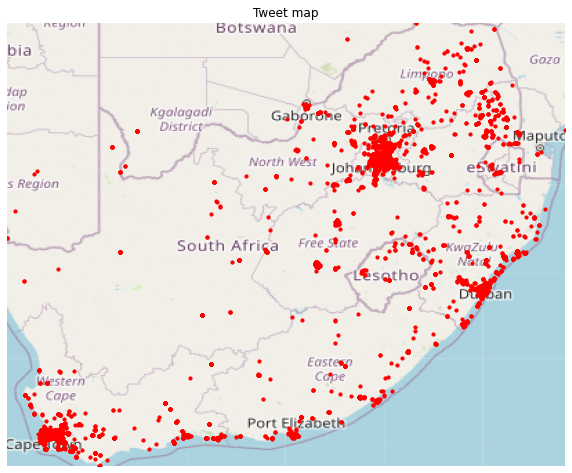

In [13]:
#Show the collected tweets on a map
places = []
for i in tweets['place']:
    try:
        places.append(i['coordinates'])
    except:
        continue

ruh_m = plt.imread('/Users/tomashegewisch/research_project/Tomas/data/map.png')
map_points = pd.DataFrame(places)
map_points.columns = ['latitude', 'longitude']

#Latitude: -28.4793 Longitude: 24.6727.

fig, ax = plt.subplots(figsize = (10,9))
ax.scatter(map_points.longitude, map_points.latitude, zorder=1, alpha= 1, c='red', s=10)

BBox = ((map_points.longitude.min(),   map_points.longitude.max(),      
         map_points.latitude.min(), map_points.latitude.max()))

ax.set_title('Tweet map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.axis("off") 
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/tweet_Map.png")

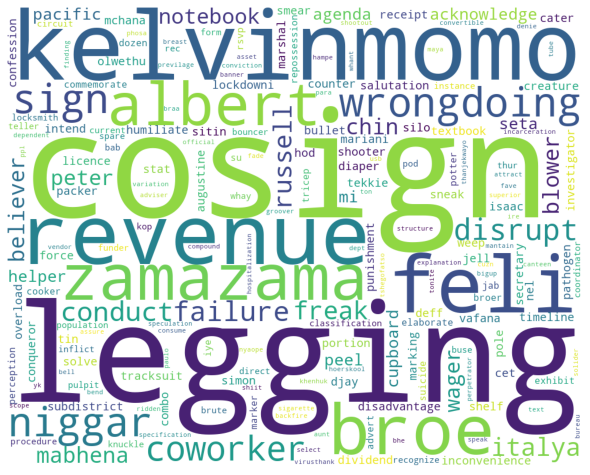

<Figure size 432x288 with 0 Axes>

In [15]:
#word Cloud all words... no hash tags .. no mentions
from wordcloud import WordCloud, STOPWORDS 
hashtags = []
# #create a list of hashtages
for i in tweets['hashtags']:
    for j in i:
        hashtags.append(j)
        
mentions = []
for i in tweets['mentions']:
    for j in i:
        mentions.append(j['screen_name'])

x = set(word_list[0].tolist())
y = set(hashtags)
x.difference_update(y)
cleaned_words_no_hashtags = list(x)

x2 = set(cleaned_words_no_hashtags)
y2 = set(mentions)
x2.difference_update(y2)
cleaned_words_no_hashtags = list(x2)

text=" ".join(cleaned_words_no_hashtags)

wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(text)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/All_words.png")

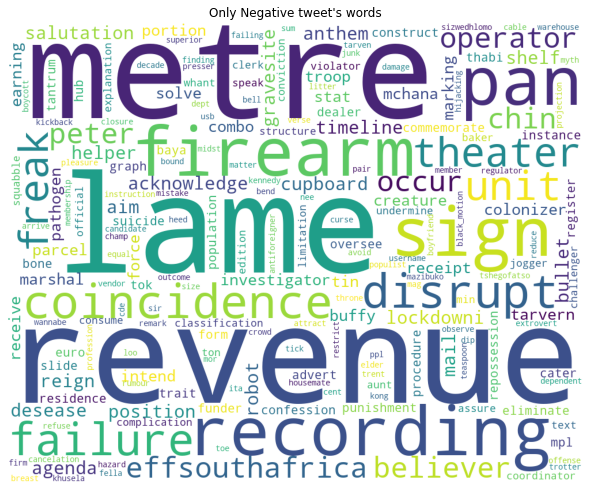

<Figure size 432x288 with 0 Axes>

In [20]:
# word cloud with negitive sentimnet tweets.
negitive_tweets_words_list = []

for i in range(0, len(tweets)):
    try:
        if tweets['senti_values'][i] < 0:
            for j in tweets['tokenised'][i]:
                negitive_tweets_words_list.append(j)
    except:
        continue

x = set(negitive_tweets_words_list)
y = set(hashtags)
x.difference_update(y)
negitve_words_no_hashtags = list(x)

#cleaned_words_no_hashtags_negitive

text = " ".join(negitve_words_no_hashtags)
wordcloud = WordCloud(width = 1000, height = 800, 
               background_color ='white',  
               min_font_size = 12).generate(text)  
#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Only Negative tweet's words", size = 12, color = "black")
plt.tight_layout(pad = 0)
plt.show()
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/negitive_words.png")

676165
537302


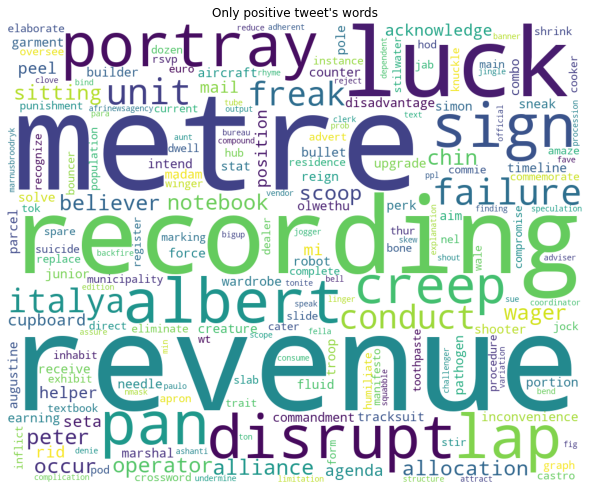

<Figure size 432x288 with 0 Axes>

In [44]:
# word cloud with negitive positive tweets.
positive_tweets_words_list = []

for i in range(0, len(tweets)):
    try:
        if tweets['senti_values'][i] > 0:
            for j in tweets['tokenised'][i]:
                positive_tweets_words_list.append(j)
    except Exception as e:
        continue
print(len(positive_tweets_words_list))
print(len(hashtags))
x1 = set(positive_tweets_words_list)
y1 = set(hashtags)
x1.difference_update(y1)
text = " ".join(list(x1))
wordcloud = WordCloud(width = 1000, height = 800, 
               background_color ='white',  
               min_font_size = 12).generate(text)  
#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Only positive tweet's words", size = 12, color = "black")
plt.tight_layout(pad = 0)
plt.show()
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/positive_words.png")